In [1]:
import pandas as pd
import json
import numpy as np
from datetime import datetime
import boto3
import time
from time import sleep
from lxml import html
import os

### Amazon のデータをダウンロード

In [2]:
data_dir = 'raw_data'

if not os.path.exists("raw_data"):
    !mkdir $data_dir

if not os.path.exists("raw_data/meta_Prime_Pantry.json.gz"):
    !cd $data_dir && \
        wget --tries=3 http://jmcauley.ucsd.edu/data/amazon_v2/categoryFiles/Prime_Pantry.json.gz && \
        wget --tries=3 http://jmcauley.ucsd.edu/data/amazon_v2/metaFiles2/meta_Prime_Pantry.json.gz

### データ読み込み

In [3]:
pantry_df = pd.read_json(data_dir + '/Prime_Pantry.json.gz', lines=True, compression='infer')
pantry_df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
0,5,True,"12 14, 2014",A1NKJW0TNRVS7O,B0000DIWNZ,Tamara M.,Good clinging,Clings well,1418515200,NaN,NaN,NaN
1,4,True,"11 20, 2014",A2L6X37E8TFTCC,B0000DIWNZ,Amazon Customer,Fantastic buy and a good plastic wrap. Even t...,Saran could use more Plus to Cling better.,1416441600,NaN,NaN,NaN
2,4,True,"10 11, 2014",A2WPR4W6V48121,B0000DIWNZ,noname,ok,Four Stars,1412985600,NaN,NaN,NaN
3,3,False,"09 1, 2014",A27EE7X7L29UMU,B0000DIWNZ,ZapNZs,Saran Cling Plus is kind of like most of the C...,"The wrap is fantastic, but the dispensing, cut...",1409529600,4,NaN,NaN
4,4,True,"08 10, 2014",A1OWT4YZGB5GV9,B0000DIWNZ,Amy Rogers,This is my go to plastic wrap so there isn't m...,has been doing it's job for years,1407628800,NaN,NaN,NaN


In [4]:
pantry_df.shape

(471614, 12)

### インタラクションデータセットの構築と保存

In [5]:
positive_reviews_df = pantry_df[pantry_df['overall'] > 3]
positive_reviews_df.shape

(387692, 12)

In [6]:
positive_reviews_df = positive_reviews_df[['reviewerID', 'asin', 'unixReviewTime', 'overall']]
positive_reviews_df['EVENT_TYPE']='reviewed'

positive_reviews_df.head()

,reviewerID,asin,unixReviewTime,overall,EVENT_TYPE
0,A1NKJW0TNRVS7O,B0000DIWNZ,1418515200,5,reviewed
1,A2L6X37E8TFTCC,B0000DIWNZ,1416441600,4,reviewed
2,A2WPR4W6V48121,B0000DIWNZ,1412985600,4,reviewed
4,A1OWT4YZGB5GV9,B0000DIWNZ,1407628800,4,reviewed
5,A1GN2ADKF1IE7K,B0000DIWNZ,1405296000,5,reviewed


### サニティチェック 試しに１つの unixReviewTime を確認して、日付データが正しいか確認する

In [7]:
time_stamp = positive_reviews_df.iloc[50]['unixReviewTime']
print(time_stamp)
print(datetime.utcfromtimestamp(time_stamp).strftime('%Y-%m-%d %H:%M:%S'))

1321488000
2011-11-17 00:00:00


In [8]:
positive_reviews_df['unixReviewTime'].map(
    lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')
).describe(include='all')

count                  387692
unique                   3654
top       2016-07-14 00:00:00
freq                      681
Name: unixReviewTime, dtype: object

In [9]:
positive_reviews_df.describe(include='all')

,reviewerID,asin,unixReviewTime,overall,EVENT_TYPE
count,387692,387692,3.876920e+05,387692.000000,387692
unique,202254,10584,NaN,NaN,1
top,A35Q0RBM3YNQNF,B00XA9DADC,NaN,NaN,reviewed
freq,176,5288,NaN,NaN,387692
mean,NaN,NaN,1.468847e+09,4.847227,NaN
std,NaN,NaN,4.314975e+07,0.359769,NaN
min,NaN,NaN,1.073693e+09,4.000000,NaN
25%,NaN,NaN,1.447200e+09,5.000000,NaN
50%,NaN,NaN,1.474718e+09,5.000000,NaN
75%,NaN,NaN,1.498435e+09,5.000000,NaN


### Personalizeが期待するカラムの名前と一致するように、カラムの名前を変更する

In [10]:
positive_reviews_df.rename(columns = {'reviewerID':'USER_ID', 'asin':'ITEM_ID', 
                              'unixReviewTime':'TIMESTAMP', 'overall': 'EVENT_VALUE'}, inplace = True)
positive_reviews_df.head()

,USER_ID,ITEM_ID,TIMESTAMP,EVENT_VALUE,EVENT_TYPE
0,A1NKJW0TNRVS7O,B0000DIWNZ,1418515200,5,reviewed
1,A2L6X37E8TFTCC,B0000DIWNZ,1416441600,4,reviewed
2,A2WPR4W6V48121,B0000DIWNZ,1412985600,4,reviewed
4,A1OWT4YZGB5GV9,B0000DIWNZ,1407628800,4,reviewed
5,A1GN2ADKF1IE7K,B0000DIWNZ,1405296000,5,reviewed


In [11]:
positive_reviews_df.describe(include='all')

,USER_ID,ITEM_ID,TIMESTAMP,EVENT_VALUE,EVENT_TYPE
count,387692,387692,3.876920e+05,387692.000000,387692
unique,202254,10584,NaN,NaN,1
top,A35Q0RBM3YNQNF,B00XA9DADC,NaN,NaN,reviewed
freq,176,5288,NaN,NaN,387692
mean,NaN,NaN,1.468847e+09,4.847227,NaN
std,NaN,NaN,4.314975e+07,0.359769,NaN
min,NaN,NaN,1.073693e+09,4.000000,NaN
25%,NaN,NaN,1.447200e+09,5.000000,NaN
50%,NaN,NaN,1.474718e+09,5.000000,NaN
75%,NaN,NaN,1.498435e+09,5.000000,NaN


### Amazon Personalize にアップロードするために CSVファイル化する

In [12]:
interactions_filename = "interactions.csv"
positive_reviews_df.to_csv(interactions_filename, index=False, float_format='%.0f')

### メタデータ

In [13]:
pantry_meta_df = pd.read_json('raw_data/meta_Prime_Pantry.json.gz', lines=True, compression='infer')
pantry_meta_df.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Sink your sweet tooth into MILK DUDS Candya d...,,"HERSHEY'S Milk Duds Candy, 5 Ounce(Halloween C...","[B019KE37WO, B007NQSWEU]",,Milk Duds,[],[],[],"{'ASIN: ': 'B00005BPJO', 'Item model number:':...","<img src=""https://m.media-amazon.com/images/G/...",,NaT,$5.00,B00005BPJO,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
1,[],,[Sink your sweet tooth into MILK DUDS Candya d...,,"HERSHEY'S Milk Duds Candy, 5 Ounce(Halloween C...","[B019KE37WO, B007NQSWEU]",,Milk Duds,[],[],[],"{'ASIN: ': 'B00005BPJO', 'Item model number:':...","<img src=""https://m.media-amazon.com/images/G/...",,NaT,$5.00,B00005BPJO,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
2,[],,[A perfect Lentil soup starts with Goya Lentil...,,"Goya Dry Lentils, 16 oz","[B003SI144W, B000VDRKEK]",,Goya,[],[],"[B074MFVZG7, B079PTH69L, B000VDRKEK, B074M9T81...",{'ASIN: ': 'B0000DIF38'},"<img src=""https://images-na.ssl-images-amazon....",,NaT,,B0000DIF38,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
3,[],,[Saran Premium Wrap is an extra tough yet easy...,,"Saran Premium Plastic Wrap, 100 Sq Ft","[B01MY5FHT6, B000PYF8VM, B000SRMDFA, B07CX6LN8...",,Saran,[],[],"[B077QLSLRQ, B00JPKW1RQ, B000FE2IK6, B00XUJHJ9...",{'Domestic Shipping: ': 'This item can only be...,"<img src=""https://images-na.ssl-images-amazon....",,NaT,,B0000DIWNI,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[200 sq ft (285 ft x 11-3/4 in x 18.6 m2). Eas...,,"Saran Cling Plus Plastic Wrap, 200 Sq Ft",[],,Saran,[],[],[B0014CZ0TE],{'Domestic Shipping: ': 'This item can only be...,"<img src=""https://images-na.ssl-images-amazon....",,NaT,,B0000DIWNZ,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [14]:
items_df = pantry_meta_df.copy()
items_df = items_df[['asin', 'brand', 'price', 'description']]
print(items_df.shape)
items_df.head(10)

(10813, 4)


,asin,brand,price,description
0,B00005BPJO,Milk Duds,$5.00,[Sink your sweet tooth into MILK DUDS Candya d...
1,B00005BPJO,Milk Duds,$5.00,[Sink your sweet tooth into MILK DUDS Candya d...
2,B0000DIF38,Goya,,[A perfect Lentil soup starts with Goya Lentil...
3,B0000DIWNI,Saran,,[Saran Premium Wrap is an extra tough yet easy...
4,B0000DIWNZ,Saran,,[200 sq ft (285 ft x 11-3/4 in x 18.6 m2). Eas...
5,B0000GH6UG,Ibarra,,"[Ibarra Chocolate, 19 Oz, , ]"
6,B0000KC2BK,Knorr,$3.09,[Knorr Granulated Chicken Flavor Bouillon is a...
7,B0001E1IN8,Castillo,,[Red chili habanero sauces. They are present t...
8,B00032E8XK,Chicken of the Sea,$1.48,[Chicken of the Sea Solid White Albacore Tuna ...
9,B0005XMTHE,Smucker's,$2.29,"[Helps build muscles with bcaa's amino acids, ..."


In [15]:
items_df["description"].iloc[0]

['Sink your sweet tooth into MILK DUDS Candya delicious blend of smooth milk chocolate and chewy caramel. These bite-sized candies are perfect for popping whether youre at home, on the go, or watching movies with friends. Stock up and always have a mouthwatering treat within reach.']

### asinカラムの値に基づいて重複行を削除

In [16]:
items_df = items_df.drop_duplicates(subset=['asin'], keep='last')
items_df.shape

(10812, 4)

In [17]:
items_df['description']

1        [Sink your sweet tooth into MILK DUDS Candya d...
2        [A perfect Lentil soup starts with Goya Lentil...
3        [Saran Premium Wrap is an extra tough yet easy...
4        [200 sq ft (285 ft x 11-3/4 in x 18.6 m2). Eas...
5                            [Ibarra Chocolate, 19 Oz, , ]
                               ...                        
10808    [These bars are where our journey started and ...
10809    [These bars are where our journey started and ...
10810    [These bars are where our journey started and ...
10811    [These bars are where our journey started and ...
10812    [Delicious, crowd pleasing and convenient it c...
Name: description, Length: 10812, dtype: object

### 文字列の配列として表現されている description を文字列に変換

### 説明文のクリーニングに使用するユーティリティ関数

In [18]:
def clean_markup(value):
    s = str(value).strip()
    if s != '':
        s = str(html.fromstring(s).text_content())
        s = ' '.join(s.split())
                
    return s.strip()

# Cleans and reformats the description column value for a dataframe row.
def clean_and_reformat_description(row):
    s = ''
    for el in row['description']:
        el = clean_markup(el)
        if el != '':
            s += ' ' + el
                
    return s.strip()

In [19]:
items_df['description'] = items_df.apply(clean_and_reformat_description, axis=1)
items_df.head()

,asin,brand,price,description
1,B00005BPJO,Milk Duds,$5.00,Sink your sweet tooth into MILK DUDS Candya de...
2,B0000DIF38,Goya,,A perfect Lentil soup starts with Goya Lentils...
3,B0000DIWNI,Saran,,Saran Premium Wrap is an extra tough yet easy ...
4,B0000DIWNZ,Saran,,200 sq ft (285 ft x 11-3/4 in x 18.6 m2). Easy...
5,B0000GH6UG,Ibarra,,"Ibarra Chocolate, 19 Oz"


### price カラムを数値に変換

In [20]:
items_df['price'].value_counts()

price
          4063
$2.99      114
$3.99      113
$4.99      103
$5.99       87
          ... 
$12.93       1
$20.80       1
$13.97       1
$11.46       1
$4.32        1
Name: count, Length: 1482, dtype: int64

In [21]:
items_df['price']

1        $5.00
2             
3             
4             
5             
         ...  
10808    $3.98
10809    $5.81
10810    $4.98
10811    $5.81
10812    $6.82
Name: price, Length: 10812, dtype: object

#### 空または数値以外の価格をnp.nanに変換し、それ以外はすべて$の通貨記号を削除します。これにより、型をfloatに強制する

In [22]:
def convert_price(row):
    v = str(row['price']).strip().replace('$', '')
    if v == '' or not v.lstrip('-').replace('.', '').isdigit():
        return np.nan
    return v

items_df['price'] = items_df.apply(convert_price, axis=1)
items_df

,asin,brand,price,description
1,B00005BPJO,Milk Duds,5.00,Sink your sweet tooth into MILK DUDS Candya de...
2,B0000DIF38,Goya,NaN,A perfect Lentil soup starts with Goya Lentils...
3,B0000DIWNI,Saran,NaN,Saran Premium Wrap is an extra tough yet easy ...
4,B0000DIWNZ,Saran,NaN,200 sq ft (285 ft x 11-3/4 in x 18.6 m2). Easy...
5,B0000GH6UG,Ibarra,NaN,"Ibarra Chocolate, 19 Oz"
...,...,...,...,...
10808,B01HI76312,KIND,3.98,These bars are where our journey started and i...
10809,B01HI76790,KIND,5.81,These bars are where our journey started and i...
10810,B01HI76SA8,KIND,4.98,These bars are where our journey started and i...
10811,B01HI76XS0,KIND,5.81,These bars are where our journey started and i...


In [23]:
items_df['price'].value_counts()

price
2.99     114
3.99     113
4.99     103
5.99      87
2.98      76
        ... 
7.62       1
16.18      1
21.84      1
12.93      1
4.32       1
Name: count, Length: 1480, dtype: int64

### Amazon Personalize 向けにカラム名を変更

In [24]:
items_df.rename(columns = {'asin':'ITEM_ID', 'brand':'BRAND', 
                              'price':'PRICE', 'description': 'DESCRIPTION'}, inplace = True)
items_df.head(10)

,ITEM_ID,BRAND,PRICE,DESCRIPTION
1,B00005BPJO,Milk Duds,5.00,Sink your sweet tooth into MILK DUDS Candya de...
2,B0000DIF38,Goya,NaN,A perfect Lentil soup starts with Goya Lentils...
3,B0000DIWNI,Saran,NaN,Saran Premium Wrap is an extra tough yet easy ...
4,B0000DIWNZ,Saran,NaN,200 sq ft (285 ft x 11-3/4 in x 18.6 m2). Easy...
5,B0000GH6UG,Ibarra,NaN,"Ibarra Chocolate, 19 Oz"
6,B0000KC2BK,Knorr,3.09,Knorr Granulated Chicken Flavor Bouillon is a ...
7,B0001E1IN8,Castillo,NaN,Red chili habanero sauces. They are present to...
8,B00032E8XK,Chicken of the Sea,1.48,Chicken of the Sea Solid White Albacore Tuna i...
9,B0005XMTHE,Smucker's,2.29,"Helps build muscles with bcaa's amino acids, i..."
10,B0005XNE6E,Snapple,1.99,"At Snapple, we believe lifes a peach. Weve bee..."


### パーソナライズ・モデルをトレーニング用のCSVを作成
### オフラインの評価指標を比較したり、オンラインでレコメンデーションの検証を行ったりする

In [25]:
items_filename = "items-metadata.csv"
items_df.to_csv(items_filename, index=False, float_format='%.2f')

### データセットインポートジョブを使用してPersonalizeにデータセットをアップロード
### CSVをアップロードする前に、データセットグループを作成し、データセットのスキーマを作成し、データセットを作成する必要がある

### データセットグループの作成

In [26]:
region_name = 'ap-northeast-1'

AWS_ACCESS_KEY_ID = os.environ.get("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.environ.get("AWS_SECRET_ACCESS_KEY")

personalize = boto3.client(
    'personalize',
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=region_name
)

personalize_runtime = boto3.client(
    'personalize-runtime', 
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=region_name
)

In [27]:
create_dataset_group_response = personalize.create_dataset_group(
    name = "amazon-pantry-aws-similar-items"
)

dataset_group = create_dataset_group_response['datasetGroupArn']
print(json.dumps(create_dataset_group_response, indent=2))

{
  "datasetGroupArn": "arn:aws:personalize:ap-northeast-1:627614495110:dataset-group/amazon-pantry-aws-similar-items",
  "ResponseMetadata": {
    "RequestId": "ea0e717d-1608-4939-a4c5-6c9aa937c42d",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Sat, 24 May 2025 09:15:33 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "115",
      "connection": "keep-alive",
      "x-amzn-requestid": "ea0e717d-1608-4939-a4c5-6c9aa937c42d",
      "strict-transport-security": "max-age=47304000; includeSubDomains",
      "x-frame-options": "DENY",
      "cache-control": "no-cache",
      "x-content-type-options": "nosniff"
    },
    "RetryAttempts": 0
  }
}


### データセットグループが完全に作成されるには数秒かかる

In [28]:
in_progress_dataset_group_arns = [ dataset_group ]
max_time = time.time() + 3*60*60 # 3 hours

In [29]:
while time.time() < max_time:
    for dataset_group_arn in in_progress_dataset_group_arns:
        describe_dataset_group_response = personalize.describe_dataset_group(
            datasetGroupArn = dataset_group_arn
        )
        status = describe_dataset_group_response["datasetGroup"]["status"]
        if status == "ACTIVE":
            print("Dataset group create succeeded for {}".format(dataset_group_arn))
            in_progress_dataset_group_arns.remove(dataset_group_arn)
        elif status == "CREATE FAILED":
            print("Create failed for {}".format(dataset_group_arn))
            in_progress_dataset_group_arns.remove(dataset_group_arn)

    if len(in_progress_dataset_group_arns) <= 0:
        break
    else:
        print("At least one dataset group create is still in progress")
                
    time.sleep(10)

At least one dataset group create is still in progress
At least one dataset group create is still in progress
Dataset group create succeeded for arn:aws:personalize:ap-northeast-1:627614495110:dataset-group/amazon-pantry-aws-similar-items


### インタラクションデータセットのスキーマとデータセットを作成する
### Interactionsデータセットのスキーマを1つ作成し、両方のソリューションで共有します。
### スキーマは AWS アカウントのグローバルなものであり、データセットグループに固有のものではないため、このようなことが可能です。

In [30]:
interactions_schema = schema = {
    "type": "record",
    "name": "Interactions",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "TIMESTAMP",
            "type": "long"
        },
        {
            "name": "EVENT_VALUE",
            "type": "float"
        },
        {
            "name": "EVENT_TYPE",
            "type": "string"
        }
    ],
    "version": "1.0"
}

### すでに Schema を作っていたら下記を実行して削除する

In [39]:
### schemaArn の名称は、エラーメッセージからわかる
# personalize.delete_schema(
#     schemaArn="arn:aws:personalize:ap-northeast-1:627614495110:schema/amazon-pantry-interactions-1"
# )

{'ResponseMetadata': {'RequestId': '0f88275e-eda8-4e16-b5b5-7f6477c2cd52',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Sat, 24 May 2025 09:26:56 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'connection': 'keep-alive',
   'x-amzn-requestid': '0f88275e-eda8-4e16-b5b5-7f6477c2cd52',
   'strict-transport-security': 'max-age=47304000; includeSubDomains',
   'x-frame-options': 'DENY',
   'cache-control': 'no-cache',
   'x-content-type-options': 'nosniff'},
  'RetryAttempts': 0}}

In [40]:
create_schema_response = personalize.create_schema(
    name = "amazon-pantry-interactions-1",
    schema = json.dumps(interactions_schema)
)

In [41]:
interaction_schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:ap-northeast-1:627614495110:schema/amazon-pantry-interactions-1",
  "ResponseMetadata": {
    "RequestId": "84b78065-fb74-4314-a3bb-23a6e8b48935",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Sat, 24 May 2025 09:28:42 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "99",
      "connection": "keep-alive",
      "x-amzn-requestid": "84b78065-fb74-4314-a3bb-23a6e8b48935",
      "strict-transport-security": "max-age=47304000; includeSubDomains",
      "x-frame-options": "DENY",
      "cache-control": "no-cache",
      "x-content-type-options": "nosniff"
    },
    "RetryAttempts": 0
  }
}


### 先ほど作成したスキーマを指定して、データセットグループにInteractionsデータセットを作成する

In [42]:
dataset_type = "INTERACTIONS"
create_dataset_response = personalize.create_dataset(
    name = "amazon-pantry-ints",
    datasetType = dataset_type,
    datasetGroupArn = dataset_group,
    schemaArn = interaction_schema_arn
)

interactions_dataset = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:ap-northeast-1:627614495110:dataset/amazon-pantry-aws-similar-items/INTERACTIONS",
  "ResponseMetadata": {
    "RequestId": "a384aa3e-1ee7-4c3c-b54c-9b81c432488e",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Sat, 24 May 2025 09:28:42 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "117",
      "connection": "keep-alive",
      "x-amzn-requestid": "a384aa3e-1ee7-4c3c-b54c-9b81c432488e",
      "strict-transport-security": "max-age=47304000; includeSubDomains",
      "x-frame-options": "DENY",
      "cache-control": "no-cache",
      "x-content-type-options": "nosniff"
    },
    "RetryAttempts": 0
  }
}


### S3でインタラクションCSVをステージングする
### 先ほど作成したInteractions CSVを先ほど作成したPersonalizeデータセットにアップロードする前に、S3バケットにCSVをステージングする必要がある
### S3バケットを作成し、Interactions CSVファイルをバケットにコピーしよう。

In [43]:
s3 = boto3.client(
    's3',
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=region_name,    
)

account_id = boto3.client(
    'sts',
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=region_name,
).get_caller_identity().get('Account')

bucket_name = "amazon-pantry-personalize-example-"+account_id

print(bucket_name)

if region_name == "us-east-1":
    s3.create_bucket(Bucket=bucket_name)
else:
    s3.create_bucket(
        Bucket=bucket_name,
        CreateBucketConfiguration={'LocationConstraint': region_name}
    )

amazon-pantry-personalize-example-627614495110


### S3 へのアップロード

In [54]:
boto3.Session().resource(
    's3',
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=region_name,
).Bucket(bucket_name).Object(interactions_filename).upload_file(interactions_filename)

### S3バケットポリシーとIAMロールの作成
### データセットのインポートジョブをPersonalizeに送信する前に、Personalizeにバケットへのアクセス権を与えるバケットポリシーとIAMロールを作成する必要があります。

In [45]:
policy = {
    "Version": "2012-10-17",
    "Id": "PersonalizeS3BucketAccessPolicy",
    "Statement": [
        {
            "Sid": "PersonalizeS3BucketAccessPolicy",
            "Effect": "Allow",
            "Principal": {
                "Service": "personalize.amazonaws.com"
            },
            "Action": [
                "s3:*Object",
                "s3:ListBucket"
            ],
            "Resource": [
                f"arn:aws:s3:::{bucket_name}",
                f"arn:aws:s3:::{bucket_name}/*",
            ]
        }
    ]
}

s3.put_bucket_policy(Bucket=bucket_name, Policy=json.dumps(policy))

{'ResponseMetadata': {'RequestId': 'WB2FAX3D27K5ZE8E',
  'HostId': 'MJn0qiUOnv65LYB9w9TdXRWDQRzVaXZazvYTqd9CKCEDKdQj+VSKneKv4I1/z4Lz2VBFLKr/jrvY0dXJyAceaAPrbel1w11S',
  'HTTPStatusCode': 204,
  'HTTPHeaders': {'x-amz-id-2': 'MJn0qiUOnv65LYB9w9TdXRWDQRzVaXZazvYTqd9CKCEDKdQj+VSKneKv4I1/z4Lz2VBFLKr/jrvY0dXJyAceaAPrbel1w11S',
   'x-amz-request-id': 'WB2FAX3D27K5ZE8E',
   'date': 'Sat, 24 May 2025 09:28:46 GMT',
   'server': 'AmazonS3'},
  'RetryAttempts': 0}}

In [48]:
iam = boto3.client(
    "iam",
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=region_name,
)

role_name = "PersonalizeRoleAmazonPantryAwsSimilarItems"
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
          "Effect": "Allow",
          "Principal": {
            "Service": "personalize.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
        }
    ]
}

try:
    create_role_response = iam.create_role(
        RoleName = role_name,
        AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
    )
except:
    create_role_response = iam.get_role(RoleName=role_name)

### AmazonPersonalizeFullAccess は 「personalize」 または 「Personalize」 を含む名前の S3 バケットへのアクセスを提供します。
### もし別の名前のバケットを使いたい場合は、新しいポリシーを作成して添付することを検討してください。
### バケットへの読み込みアクセスを提供する新しいポリシーを作成して添付するか、AmazonS3ReadOnlyAccessポリシーをロールに添付することを検討してください。

In [49]:
# policy_arn = "arn:aws:iam::aws:policy/service-role/AmazonPersonalizeFullAccess"
# iam.attach_role_policy(
#     RoleName = role_name,
#     PolicyArn = policy_arn
# )

# # Now add S3 support
# iam.attach_role_policy(
#     PolicyArn='arn:aws:iam::aws:policy/AmazonS3FullAccess',
#     RoleName=role_name
# )
# time.sleep(20) # wait for a minute to allow IAM role policy attachment to propagate

role_arn = create_role_response["Role"]["Arn"]
print(role_arn)

arn:aws:iam::627614495110:role/PersonalizeRoleAmazonPantryAwsSimilarItems


### 相互作用データセットのインポート
### S3バケットにあるステージングされたInteractions CSVを、作成したPersonalizeデータセットにインポートする準備を行う

In [55]:
create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "amazon-pantry-interactions-import",
    datasetArn = interactions_dataset,
    dataSource = {
        "dataLocation": f"s3://{bucket_name}/{interactions_filename}"
    },
    roleArn = role_arn
)

dataset_import_job = create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:ap-northeast-1:627614495110:dataset-import-job/amazon-pantry-interactions-import",
  "ResponseMetadata": {
    "RequestId": "badd1a37-1031-4c57-bef8-487bcffece50",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Sat, 24 May 2025 09:46:01 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "126",
      "connection": "keep-alive",
      "x-amzn-requestid": "badd1a37-1031-4c57-bef8-487bcffece50",
      "strict-transport-security": "max-age=47304000; includeSubDomains",
      "x-frame-options": "DENY",
      "cache-control": "no-cache",
      "x-content-type-options": "nosniff"
    },
    "RetryAttempts": 0
  }
}


### アイテム・データセット・スキーマとデータセットの作成

In [56]:
item_schema = {
    "type": "record",
    "name": "Items",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "BRAND",
            "type": [ "null", "string" ],
            "categorical": True
        },{
            "name": "PRICE",
            "type": [ "null", "float" ],
        },{
            "name": "DESCRIPTION",
            "type": [ "null", "string" ],
            "textual": True
        }
    ],
    "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = "amazon-pantry-items-schema",
    schema = json.dumps(item_schema)
)

item_schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:ap-northeast-1:627614495110:schema/amazon-pantry-items-schema",
  "ResponseMetadata": {
    "RequestId": "5b47c082-296e-4a94-a3fb-342d86f26669",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Sat, 24 May 2025 09:46:28 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "97",
      "connection": "keep-alive",
      "x-amzn-requestid": "5b47c082-296e-4a94-a3fb-342d86f26669",
      "strict-transport-security": "max-age=47304000; includeSubDomains",
      "x-frame-options": "DENY",
      "cache-control": "no-cache",
      "x-content-type-options": "nosniff"
    },
    "RetryAttempts": 0
  }
}


### すでに Schema を作っていたら下記を実行して削除する

In [ ]:
### schemaArn の名称は、エラーメッセージからわかる
# personalize.delete_schema(
#     schemaArn="arn:aws:personalize:ap-northeast-1:627614495110:schema/amazon-pantry-interactions-1"
# )

In [57]:
dataset_type = "ITEMS"
create_dataset_response = personalize.create_dataset(
    name = "amazon-pantry-items",
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = item_schema_arn
)

items_dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:ap-northeast-1:627614495110:dataset/amazon-pantry-aws-similar-items/ITEMS",
  "ResponseMetadata": {
    "RequestId": "d2d97e7a-deae-4ea0-b79b-0362b5e9ea70",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Sat, 24 May 2025 09:46:40 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "110",
      "connection": "keep-alive",
      "x-amzn-requestid": "d2d97e7a-deae-4ea0-b79b-0362b5e9ea70",
      "strict-transport-security": "max-age=47304000; includeSubDomains",
      "x-frame-options": "DENY",
      "cache-control": "no-cache",
      "x-content-type-options": "nosniff"
    },
    "RetryAttempts": 0
  }
}


In [ ]:
boto3.Session().resource(
    's3',
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=region_name,
).Bucket(bucket_name).Object(items_filename).upload_file(items_filename)

### 各データセットグループのアイテムデータセットをインポートする

In [58]:
create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "amazon-pantry-items-import-job",
    datasetArn = items_dataset_arn,
    dataSource = {
        "dataLocation": f"s3://{bucket_name}/{items_filename}"
    },
    roleArn = role_arn
)

dataset_import_job_items_arn = create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:ap-northeast-1:627614495110:dataset-import-job/amazon-pantry-items-import-job",
  "ResponseMetadata": {
    "RequestId": "0f1002bb-ae63-445e-8f50-57187be6baab",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Sat, 24 May 2025 09:49:45 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "123",
      "connection": "keep-alive",
      "x-amzn-requestid": "0f1002bb-ae63-445e-8f50-57187be6baab",
      "strict-transport-security": "max-age=47304000; includeSubDomains",
      "x-frame-options": "DENY",
      "cache-control": "no-cache",
      "x-content-type-options": "nosniff"
    },
    "RetryAttempts": 0
  }
}


### 相互作用データセットのインポートジョブの完了を待つ
### 次のセルは、両方のインポート・ジョブが完了するまで待機します。

In [59]:
%%time

in_progress_import_arns = [ dataset_import_job ]

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    for import_arn in in_progress_import_arns:
        describe_dataset_import_job_response = personalize.describe_dataset_import_job(
            datasetImportJobArn = import_arn
        )
        status = describe_dataset_import_job_response["datasetImportJob"]['status']
        if status == "ACTIVE":
            print("Dataset import succeeded for {}".format(import_arn))
            in_progress_import_arns.remove(import_arn)
        elif status == "CREATE FAILED":
            print("Create failed for {}".format(import_arn))
            in_progress_import_arns.remove(import_arn)

    if len(in_progress_import_arns) <= 0:
        break
    else:
        print("At least one dataset import job is still in progress")
                
    time.sleep(60)

Dataset import succeeded for arn:aws:personalize:ap-northeast-1:627614495110:dataset-import-job/amazon-pantry-interactions-import
CPU times: user 18.1 ms, sys: 3.13 ms, total: 21.2 ms
Wall time: 121 ms


### Itemsインポートジョブの完了を待つ
### 以下のロジックは、両方のアイテムデータセットが各データセットグループに完全にインポートされるまで待機します。

In [60]:
%%time

in_progress_import_arns = [ dataset_import_job_items_arn ]

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    for import_arn in in_progress_import_arns:
        describe_dataset_import_job_response = personalize.describe_dataset_import_job(
            datasetImportJobArn = import_arn
        )
        status = describe_dataset_import_job_response["datasetImportJob"]['status']
        if status == "ACTIVE":
            print("Dataset import succeeded for {}".format(import_arn))
            in_progress_import_arns.remove(import_arn)
        elif status == "CREATE FAILED":
            print("Create failed for {}".format(import_arn))
            in_progress_import_arns.remove(import_arn)

    if len(in_progress_import_arns) <= 0:
        break
    else:
        print("At least one dataset import job is still in progress")
                
    time.sleep(60)

At least one dataset import job is still in progress
At least one dataset import job is still in progress
At least one dataset import job is still in progress
Dataset import succeeded for arn:aws:personalize:ap-northeast-1:627614495110:dataset-import-job/amazon-pantry-items-import-job
CPU times: user 119 ms, sys: 13.4 ms, total: 132 ms
Wall time: 3min 2s


### ソリューションとソリューションバージョンの作成

### 各データセットグループのデータのユーザパーソナライズのレシピを使って、ソリューションとソリューションのバージョンを作成します。
### まず、利用可能なパーソナライズレシピを列挙します。

In [61]:
personalize.list_recipes()

{'recipes': [{'name': 'aws-ecomm-customers-who-viewed-x-also-viewed',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-ecomm-customers-who-viewed-x-also-viewed',
   'status': 'ACTIVE',
   'creationDateTime': datetime.datetime(2019, 6, 10, 0, 0, tzinfo=tzlocal()),
   'lastUpdatedDateTime': datetime.datetime(2024, 6, 21, 21, 49, 44, 731000, tzinfo=tzlocal()),
   'domain': 'ECOMMERCE'},
  {'name': 'aws-ecomm-frequently-bought-together',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-ecomm-frequently-bought-together',
   'status': 'ACTIVE',
   'creationDateTime': datetime.datetime(2019, 6, 10, 0, 0, tzinfo=tzlocal()),
   'lastUpdatedDateTime': datetime.datetime(2024, 6, 21, 21, 49, 44, 731000, tzinfo=tzlocal()),
   'domain': 'ECOMMERCE'},
  {'name': 'aws-ecomm-popular-items-by-purchases',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-ecomm-popular-items-by-purchases',
   'status': 'ACTIVE',
   'creationDateTime': datetime.datetime(2019, 6, 10, 0, 0, tzinfo=tzlocal()),
   'lastUpdat

### レシピの選択

In [62]:
sims_recipe_arn = "arn:aws:personalize:::recipe/aws-sims"
similar_items_recipe_arn = "arn:aws:personalize:::recipe/aws-similar-items"

### まず、各レシピのソリューションとソリューション・バージョンを作成する。

In [63]:
sims_create_solution_response = personalize.create_solution(
    name = "amazon-pantry-sims-solution-example",
    datasetGroupArn = dataset_group_arn,
    recipeArn = sims_recipe_arn
)

sims_solution_arn = sims_create_solution_response['solutionArn']

In [64]:
sims_solution_version_response = personalize.create_solution_version(
    solutionArn = sims_solution_arn
)

In [69]:
sims_solution_version_arn = sims_solution_version_response['solutionVersionArn']
print(json.dumps(sims_solution_version_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:ap-northeast-1:627614495110:solution/amazon-pantry-sims-solution-example/23862e46",
  "ResponseMetadata": {
    "RequestId": "e1979c23-9337-4987-855a-21e2c4dcff88",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Sat, 24 May 2025 10:22:45 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "126",
      "connection": "keep-alive",
      "x-amzn-requestid": "e1979c23-9337-4987-855a-21e2c4dcff88",
      "strict-transport-security": "max-age=47304000; includeSubDomains",
      "x-frame-options": "DENY",
      "cache-control": "no-cache",
      "x-content-type-options": "nosniff"
    },
    "RetryAttempts": 0
  }
}


### 次に、項目の説明を含むソリューションとソリューション・バージョンをデータセット・グループに作成します。

In [65]:
similar_items_create_solution_response = personalize.create_solution(
    name = "amazon-pantry-aws-similar-items-solution-example",
    datasetGroupArn = dataset_group_arn,
    recipeArn = similar_items_recipe_arn
)

similar_items_solution_arn = similar_items_create_solution_response['solutionArn']

In [66]:
similar_items_solution_version_response = personalize.create_solution_version(
    solutionArn = similar_items_solution_arn
)

In [67]:
similar_items_solution_version_arn = similar_items_solution_version_response['solutionVersionArn']
print(json.dumps(similar_items_solution_version_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:ap-northeast-1:627614495110:solution/amazon-pantry-aws-similar-items-solution-example/23c3d787",
  "ResponseMetadata": {
    "RequestId": "a5fa93e1-ba38-4a13-b91f-16a274de104e",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "date": "Sat, 24 May 2025 10:22:47 GMT",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "139",
      "connection": "keep-alive",
      "x-amzn-requestid": "a5fa93e1-ba38-4a13-b91f-16a274de104e",
      "strict-transport-security": "max-age=47304000; includeSubDomains",
      "x-frame-options": "DENY",
      "cache-control": "no-cache",
      "x-content-type-options": "nosniff"
    },
    "RetryAttempts": 0
  }
}


### ソリューション・バージョンがアクティブになるのを待つ
### 最後に、ソリューションバージョンが作成され終わるのを待ちます。このステップでPersonalizeはデータセットと選択されたレシピに基づいて機械学習モデルをトレーニングします。
### また、Personalizeはインタラクションのデータセットをトレーニング部分と評価部分に分割し、トレーニング済みのモデルに対するレコメンデーションの品質を評価できるようにします。
### 説明データを含むデータセットグループのソリューションバージョンは、説明データを含まないものよりもトレーニングに時間がかかることがわかります

In [70]:
%%time

in_progress_solution_versions = [
    sims_solution_version_arn,
    similar_items_solution_version_arn
]

max_time = time.time() + 10*60*60 # 10 hours
while time.time() < max_time:
    for solution_version_arn in in_progress_solution_versions:
        version_response = personalize.describe_solution_version(
            solutionVersionArn = solution_version_arn
        )
        status = version_response["solutionVersion"]["status"]
        
        if status == "ACTIVE":
            print("Build succeeded for {}".format(solution_version_arn))
            in_progress_solution_versions.remove(solution_version_arn)
        elif status == "CREATE FAILED":
            print("Build failed for {}".format(solution_version_arn))
            in_progress_solution_versions.remove(solution_version_arn)
    
    if len(in_progress_solution_versions) <= 0:
        break
    else:
        print("At least one solution build is still in progress")
        
    time.sleep(60)

At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
Build succeeded for arn:aws:personalize:ap-northeast-1:627614495110:solution/amazon-pantry-sims-solution-example/23862e46
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progress
At least one solution build is still in progr

### 一般的に言って、構造化および非構造化テキストベースのメタデータを追加すると、学習時間が長くなる。
### 私たちの場合、商品説明のあるデータセットで学習したソリューションバージョンは、商品説明のないデータセットで学習したソリューションバージョンよりも数分長くかかったことが、上記でお分かりいただけるでしょう。この違いは、データセットの構成やテキスト値によって異なります。
### 各ソリューションバージョンの学習時間を調べ、同様に比較してみましょう。

In [72]:
response = personalize.describe_solution_version(solutionVersionArn = sims_solution_version_arn)
training_hours_sims = response['solutionVersion']['trainingHours']

response = personalize.describe_solution_version(solutionVersionArn = similar_items_solution_version_arn)
training_hours_similar_items = response['solutionVersion']['trainingHours']

training_diff = (training_hours_similar_items - training_hours_sims) / training_hours_sims

print(f"Training hours sims: {training_hours_sims}")
print(f"Training hours similar items: {training_hours_similar_items}")

print("Difference of {:.2%}".format(training_diff))

Training hours sims: 0.965
Training hours similar items: 3.515
Difference of 264.25%


### コスト計算に使用したトレーニング時間は、記述列を使用したトレーニングの方が約50％高かった。

### 壁/時計の時間とトレーニング時間は、データセットのサイズによって異なりますが、この情報が、データセットに非構造化テキストを追加することを検討する際のトレードオフを評価するのに役立ちます。

In [73]:
sims_solution = {
        "solution_arn": sims_solution_arn,
        "solution_version_arn": sims_solution_version_arn
}
similar_items_solution = {
        "solution_arn": similar_items_solution_arn,
        "solution_version_arn": similar_items_solution_version_arn
}

In [74]:
def create_campaign(solution,name):
    create_campaign_response = personalize.create_campaign(
        name = "personalize-demo-" + name + "example",
        solutionVersionArn = solution['solution_version_arn'],
        minProvisionedTPS = 1
    )

    campaign_arn = create_campaign_response['campaignArn']
    print('campaign_arn:' + campaign_arn)
    return campaign_arn

def waitForCampaign(solution):
    max_time = time.time() + 3*60*60 # 3 hours
    while time.time() < max_time:
        describe_campaign_response = personalize.describe_campaign(
            campaignArn = solution['campaign_arn']
        )
        status = describe_campaign_response["campaign"]["status"]
        print("Campaign: {} {}".format(solution['campaign_arn'], status))

        if status == "ACTIVE" or status == "CREATE FAILED":
            break

        time.sleep(60)

### 2つのキャンペーンを作成して待つ
### 各項目の類似レシピのキャンペーンを作成しますが、メタデータの追加による影響を示すため、他の設定はすべて同じにします。

In [75]:
sims_solution['campaign_arn'] = create_campaign(sims_solution, 'sims')
similar_items_solution['campaign_arn'] = create_campaign(similar_items_solution, 'aws-similar-items')

campaign_arn:arn:aws:personalize:ap-northeast-1:627614495110:campaign/personalize-demo-simsexample
campaign_arn:arn:aws:personalize:ap-northeast-1:627614495110:campaign/personalize-demo-aws-similar-itemsexample


In [76]:
waitForCampaign(sims_solution)
waitForCampaign(similar_items_solution)

Campaign: arn:aws:personalize:ap-northeast-1:627614495110:campaign/personalize-demo-simsexample CREATE PENDING
Campaign: arn:aws:personalize:ap-northeast-1:627614495110:campaign/personalize-demo-simsexample CREATE IN_PROGRESS
Campaign: arn:aws:personalize:ap-northeast-1:627614495110:campaign/personalize-demo-simsexample CREATE IN_PROGRESS
Campaign: arn:aws:personalize:ap-northeast-1:627614495110:campaign/personalize-demo-simsexample CREATE IN_PROGRESS
Campaign: arn:aws:personalize:ap-northeast-1:627614495110:campaign/personalize-demo-simsexample CREATE IN_PROGRESS
Campaign: arn:aws:personalize:ap-northeast-1:627614495110:campaign/personalize-demo-simsexample CREATE IN_PROGRESS
Campaign: arn:aws:personalize:ap-northeast-1:627614495110:campaign/personalize-demo-simsexample CREATE IN_PROGRESS
Campaign: arn:aws:personalize:ap-northeast-1:627614495110:campaign/personalize-demo-simsexample CREATE IN_PROGRESS
Campaign: arn:aws:personalize:ap-northeast-1:627614495110:campaign/personalize-demo-

### 推薦を得る
### まず、次の3種類のアイテムを選んで推論する。

### インタラクション数が多いアイテム
### インタラクション数が少ないアイテム
### ランダムなitemId
### 次に、それぞれのモデルが提供されたアイテムに対してどのように振る舞うかを見てみる

### インタラクションデータセットを見て、インタラクションされたアイテムの分布をプロットしてみよう

In [71]:
items_interacted_df = positive_reviews_df.copy()
# Getting unique aisns counts
asin_interaction_count = items_interacted_df['ITEM_ID'].value_counts()
# Transforming panda series to df
asin_interaction_count_df = pd.DataFrame({'asin':asin_interaction_count.index, 'count':asin_interaction_count.values})
asin_interaction_count_df

,asin,count
0,B00XA9DADC,5288
1,B00I3MVY9I,5086
2,B00W6T13OU,4023
3,B0014CZUZ8,3225
4,B0014CSIG6,2600
...,...,...
10579,B011OAC4O4,1
10580,B011R60JDS,1
10581,B019DKR9CO,1
10582,B00HZYETKG,1


In [77]:
asin_interaction_count_df.describe(include='int')

,count
count,10584.000000
mean,36.630008
std,123.480233
min,1.000000
25%,4.000000
50%,12.000000
75%,33.250000
max,5288.000000


### 上で見たように、最も相互作用の多いアイテムは〜5kの相互作用を持っています。
### ここで、相互作用の多いアイテムと少ないアイテムがあることがわかります。

In [82]:
import matplotlib.pyplot as plt

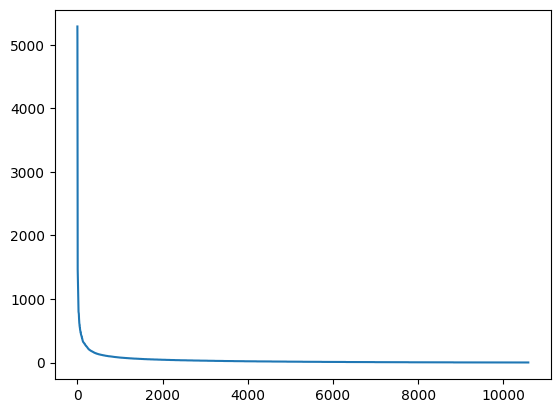

In [83]:
plt.plot(asin_interaction_count_df["count"])

### 以下では、100から300のインタラクションを持つアイテムを詳しく見ることができる。
### これらのアイテムは、テスト時に最も多様な結果をもたらすだろう。

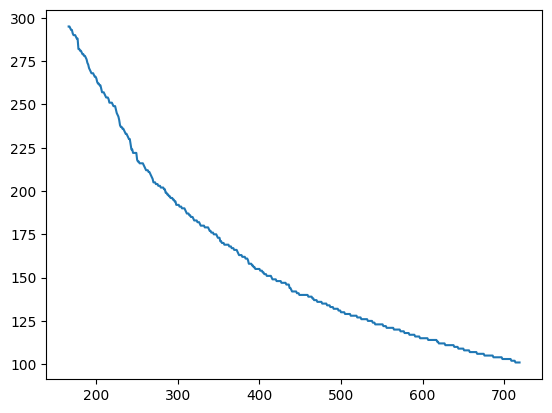

In [84]:
zoom_interactions = asin_interaction_count_df.copy()
zoom_interactions = zoom_interactions.loc[(zoom_interactions["count"] > 100) & (zoom_interactions["count"] < 300)]
plt.plot(zoom_interactions["count"])

### では、アイテムのメタデータを探索するための関数を定義してみよう。

In [85]:
def get_item_brand(item_id):
    """
    Takes in an ID, returns its brand
    """

    return items_df.query('ITEM_ID=="{}"'.format(item_id))['BRAND'].item()

def get_item_price(item_id):
    """
    Takes in an ID, returns its brand
    """

    return items_df.query('ITEM_ID=="{}"'.format(item_id))['PRICE'].item()

def get_item_description(item_id):
    """
    Takes in an ID, returns its brand
    """

    return items_df.query('ITEM_ID=="{}"'.format(item_id))['DESCRIPTION'].item()
def get_item_df(item_id):
    """
    Takes in an ID, returns a title
    """
    temp_df = items_df.query('ITEM_ID=="{}"'.format(item_id))
  
    temp_df['INTERACTIONS_COUNT'] = get_item_count(item_id)
    return temp_df

def get_item_count(item_id):
    return asin_interaction_count_df.query('asin=="{}"'.format(item_id))['count'].item()

def clean_recs_list(rec_list):
    """推薦結果をDataFrame化する"""
    items = []
    for each in rec_list:
        items.append([each['itemId'], get_item_brand(each['itemId']), get_item_price(each['itemId']), get_item_description(each['itemId']), get_item_count(each['itemId'])])
    return pd.DataFrame (items, columns = ['ITEM_ID', 'BRAND', 'PRICE','DESCRIPTION', 'INTERACTIONS_COUNT'])

def get_recs_df(item_id, campaign):
    """レコメンドの実行"""
    response = personalize_runtime.get_recommendations(
        campaignArn=campaign,
        itemId=item_id,
        numResults=10
    )
    return clean_recs_list(response['itemList'])

In [86]:
asin_interaction_count_df.sample()['asin'].item()

'B012DE8NX6'

In [87]:
asin = asin_interaction_count_df.sample(1)['asin'].item()

# 与えるデータ
recommended_item_df = get_item_df(asin)

/tmp/ipykernel_12033/1856593386.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['INTERACTIONS_COUNT'] = get_item_count(item_id)


In [93]:
print(asin)

B00NO0794I


In [88]:
# 与えたデータを元に推薦実行
recommendations_sims_df = get_recs_df(asin,sims_solution['campaign_arn'])
recommendations_similar_items_df = get_recs_df(asin,similar_items_solution['campaign_arn'])

### これが推論を実行するアイテムで、ここにブランド、価格、インタラクションの数があります。
### 理論的には、インタラクションが少ないアイテムに対して、SIMSは主に人気のあるアイテムを返し、新しいaws-item-similarityレシピは現在のアイテムのメタデータに関連するアイテムを返します。

In [89]:
# サンプリング
recommended_item_df

,ITEM_ID,BRAND,PRICE,DESCRIPTION,INTERACTIONS_COUNT
1760,B00NO0794I,vH essentials,NaN,"A healthy vagina is teeming with ""good"" bacter...",3


In [90]:
# 推薦
recommendations_sims_df

,ITEM_ID,BRAND,PRICE,DESCRIPTION,INTERACTIONS_COUNT
0,B00XA9DADC,Twinings,8.00,Made with 100% pure peppermint leaves. An upli...,5288
1,B00I3MVY9I,Crest,NaN,Unleash A Brilliantly Dimensional Smile A 3D W...,5086
2,B00W6T13OU,Brooklyn Beans,NaN,"In Brooklyn, we know a thing or two about bein...",4023
3,B00HZ6X8QU,Tide,11.99,Tide Original liquid laundry detergent provide...,1791
4,B0014CZUZ8,Planters,5.98,Nuts are the heroes of wholesome snacking. And...,3225
5,B00I9KR31C,Viva,NaN,View larger Product Description Dinner is over...,1467
6,B00W6T208I,Celestial Seasonings,NaN,A full-bodied black tea made from ingredients ...,1415
7,B00I8YJZ4M,Tom's of Maine,3.79,Toms of Maine Goodness Day Mt. Agamenticus loc...,1403
8,B00ICZZCEE,Pure Protein,7.09,"Pure Protein 23 Grams, Vanilla Creme(4 Count, ...",1429
9,B0014CSIG6,Mauna Loa,NaN,2g Net carbs. Taste of the tropics. Share this...,2600


### コスト・カテゴリーと製品グループ

In [91]:
# 推薦
recommendations_similar_items_df

,ITEM_ID,BRAND,PRICE,DESCRIPTION,INTERACTIONS_COUNT
0,B00MTSGYG0,Bounce,8.24,"We admit, the outdoors smell great. But with o...",394
1,B00O28Y4FI,Maxell,1.95,Manufactured to the highest standards in the i...,32
2,B00PTX8N52,Dawn,NaN,Think all dish soaps are the same? Think again...,621
3,B01B4N9Y6C,Cottonelle,6.99,Cottonelle Clean Care toilet paper with Clean ...,570
4,B019XEY5GS,Bounty,14.99,Ever try one of those bargain' paper towels an...,483
5,B00HZ6X8QU,Tide,11.99,Tide Original liquid laundry detergent provide...,1791
6,B00IB0CO1O,Seventh Generation,5.49,Clean doesnt have to be complicated. Seventh G...,710
7,B011DX5G92,Charmin,6.99,Charmin Ultra Strong toilet paper cleans bette...,536
8,B00NAZ532W,Viva,NaN,Unleash the paper towel that cleans like cloth...,798
9,B011KW1HXK,Clorox,3.97,Clorox Zero Splash Bleach Crystals let you cle...,251


### 説明文を印刷し、アイテムのテーマに合っているかどうか確認してみましょう。

In [92]:
for index, row in recommendations_similar_items_df.iterrows():
    print('----ITEM----')
    print('Recommendation number {index}, BRAND: {brand}, PRICE: {price}'.format(index=index+1, brand=row['BRAND'], price=row['PRICE']))
    print('----DESCRIPTION----')
    print(row['DESCRIPTION'])

----ITEM----
Recommendation number 1, BRAND: Bounce, PRICE: 8.24
----DESCRIPTION----
We admit, the outdoors smell great. But with our Bounce Outdoor Fresh fabric softener dryer sheets you also get fewer wrinkles, way less static cling, repel lint and hair while keeping your fabrics soft - all on top of an outdoor fresh scent. Ahhhhh, now thats a breath of fresh air. View larger View larger View larger View larger
----ITEM----
Recommendation number 2, BRAND: Maxell, PRICE: 1.95
----DESCRIPTION----
Manufactured to the highest standards in the industry, Maxell's alkaline batteries provide unrivaled value. You can depend on these batteries to power your emergency flashlight, your children's toys, or even your smoke alarm. Maxell batteries provide long-lasting, reliable power. You can depend on these batteries to power your emergency flashlight, your children's toys, or even your smoke alarm. Ready-to-go power source that delivers long-lasting and reliable energy. Established in the United 

### リソースのシャットダウン
### このノートブックで作成したキャンペーンは継続的な変更を生成するため、以下のロジックで削除プロセスを開始します。

In [94]:
personalize.delete_campaign(campaignArn = sims_solution['campaign_arn'])
personalize.delete_campaign(campaignArn = similar_items_solution['campaign_arn'])

{'ResponseMetadata': {'RequestId': '0f52e8c5-bb5f-4b67-9e57-3dd26c0f3b1e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Sat, 24 May 2025 11:56:37 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'connection': 'keep-alive',
   'x-amzn-requestid': '0f52e8c5-bb5f-4b67-9e57-3dd26c0f3b1e',
   'strict-transport-security': 'max-age=47304000; includeSubDomains',
   'x-frame-options': 'DENY',
   'cache-control': 'no-cache',
   'x-content-type-options': 'nosniff'},
  'RetryAttempts': 0}}